In [3]:
import os
import torch
import numpy as np
from PIL import Image
from transformers import AutoModel
from transformers import AutoVideoProcessor
import sklearn as sk
import matplotlib.pyplot as plt

/Users/shamik/Library/Mobile Documents/com~apple~CloudDocs/Documents/shampro-cloud/rpi/urp/AV-SSL-Optimization-JEPA/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
hf_model_name = (
    "facebook/vjepa2-vitl-fpc64-256"  # Replace with your favored model, e.g. facebook/vjepa2-vitg-fpc64-384
)

# initialize model weights from huggingface
model_hf = AutoModel.from_pretrained(hf_model_name)
model_hf.to("mps", dtype = torch.float32).eval() 

# load model weights
hf_transform = AutoVideoProcessor.from_pretrained(hf_model_name)


In [ ]:
# creating scenes for testing encoder

tubelet_size = 2 # size of temporal data
data_dir = 'data'
tubelet_videos = [] # elements of (tubelet_size, H, W, 3)
tubelet_meta = [] # list of (scene_name, tubelet index within scene)

# ensure deterministic scene order
scene_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

for scene in scene_names:
    folder_path = os.path.join(data_dir, scene)
    frame_files = sorted(
        f for f in os.listdir(folder_path)
        if os.path.isfile(os.path.join(folder_path, f))
    )

    frames = [] 

    # ensure deterministic frame order within each scene
    for file in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, file)
        img = Image.open(img_path).convert("RGB")
        img = img.resize((224, 224), Image.BICUBIC) # resizing to work with masking (otherwise model will resize automatically)
        frames.append(np.array(img))

    # make non-overlapping tubeletes
    num_tubelets = len(frames) // tubelet_size
    for t_idx in range(num_tubelets):
        start = t_idx * tubelet_size
        tube = np.stack(frames[start:start + tubelet_size], axis = 0)
        tubelet_videos.append(tube)
        tubelet_meta.append((scene,  t_idx))

    
    print(f"{scene}: {len(frames)} frames -> {num_tubelets} tubelets")

scene1: 16 frames -> 8 tubelets
scene2: 16 frames -> 8 tubelets
scene3: 16 frames -> 8 tubelets
scene4: 16 frames -> 8 tubelets
scene5: 16 frames -> 8 tubelets
scene6: 16 frames -> 8 tubelets


In [ ]:
# ground truth clips (unmasked)

embeddings = [] # elements of (W, ) embedding vectors

for video in tubelet_videos:
    inputs = hf_transform(video, return_tensors = 'pt')
    inputs = {k: v.to(model_hf.device) for k, v, in inputs.items()}

    with torch.no_grad():
        feats = model_hf.get_vision_features(**inputs) # (1, H, W)
        print("feats shape ", feats.shape)
        clip_emb = feats.mean(dim=1).squeeze(0).cpu().numpy() # global average pooling for downstream
        print("clim emb shape ", clip_emb.shape)
        embeddings.append(clip_emb)  


tubelet_embds = np.stack(embeddings, axis = 0) # tensor of all our embeddings

feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])


In [43]:

def mask_tubelet_pixels(tubelet: np.ndarray,
                        mask_ratio: float = 0.75,
                        patch_size: int = 16,
                        seed: int | None = None,
                        fill_value: int = 0) -> tuple[np.ndarray, np.ndarray]:
    """Return a masked copy of ``tubelet`` and a boolean patch mask.

    Args:
        tubelet: numpy array shaped (T, H, W, 3) containing uint8 RGB frames.
        mask_ratio: fraction of spatio-temporal patches to hide.
        patch_size: spatial patch size, must divide both H and W.
        seed: optional RNG seed for reproducibility.
        fill_value: pixel value used to overwrite masked regions.

    Returns:
        masked_tubelet: numpy array with selected patches overwritten.
        mask_tokens: bool array of shape (T, H/patch_size, W/patch_size) marking masked patches.
    """

    assert 0.0 <= mask_ratio <= 1.0, "mask_ratio must be within [0, 1]"
    if tubelet.ndim != 4:
        raise ValueError(f"tubelet must be rank-4 (T, H, W, C), got shape {tubelet.shape}")

    T, H, W, C = tubelet.shape
    if H % patch_size != 0 or W % patch_size != 0:
        raise ValueError("H and W must be divisible by patch_size")

    masked = tubelet.copy()
    rng = np.random.default_rng(seed)
    h_tokens = H // patch_size
    w_tokens = W // patch_size
    tokens = [(t, h, w) for t in range(T)
              for h in range(h_tokens)
              for w in range(w_tokens)]

    mask_tokens = np.zeros((T, h_tokens, w_tokens), dtype=bool)

    rng.shuffle(tokens)
    k = int(round(mask_ratio * len(tokens)))
    k = min(max(k, 0), len(tokens))

    for t, h, w in tokens[:k]:
        h0 = h * patch_size
        w0 = w * patch_size
        masked[t, h0:h0 + patch_size, w0:w0 + patch_size] = fill_value
        mask_tokens[t, h, w] = True

    return masked, mask_tokens



In [51]:

# target clip embeddings (masked)

MASK_RATIO = 0.75
PATCH_SIZE = 16
masked_embeddings = []
mask_token_list = []

for idx, video in enumerate(tubelet_videos):
    video_masked, mask_tokens = mask_tubelet_pixels(video, mask_ratio=MASK_RATIO,
                                                   patch_size=PATCH_SIZE, seed=idx, fill_value=0)
    inputs = hf_transform(video_masked, return_tensors='pt')
    inputs = {k: v.to(model_hf.device) for k, v in inputs.items()}

    with torch.no_grad():
        feats = model_hf.get_vision_features(**inputs)
        print("feats shape ", feats.shape)
        clip_emb = feats.mean(dim=1).squeeze(0).cpu().numpy()
        print("clim emb shape ", clip_emb.shape)
        masked_embeddings.append(clip_emb)
        mask_token_list.append(mask_tokens)

if masked_embeddings:
    tubelet_embds_masked = np.stack(masked_embeddings, axis=0)
    tubelet_mask_tokens = np.stack(mask_token_list, axis=0)
    print('masked embeddings tensor', tubelet_embds_masked.shape)
    print('mask tokens tensor', tubelet_mask_tokens.shape)
else:
    tubelet_embds_masked = None
    tubelet_mask_tokens = None



feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])


In [52]:
# normalize
tubelet_embds_norm = tubelet_embds / np.linalg.norm(tubelet_embds)
tubelet_embds_masked_norm = tubelet_embds_masked / np.linalg.norm(tubelet_embds_masked)



In [53]:

# computing PCA 

# Select features X: prefer tubelet embeddings if present
if 'tubelet_embds_norm' in globals():
    X = tubelet_embds_norm  # (N_tubelets, D)
    meta = tubelet_meta
    use_tubelets = True
else:
    raise RuntimeError('tubelet_embds_norm not found')

pca3 = sk.decomposition.PCA(n_components=3)
emb_3d = pca3.fit_transform(X)

pca2 = sk.decomposition.PCA(n_components = 2)
emb_2d = pca2.fit_transform(X)

emb_3d_masked = None
emb_2d_masked = None
if 'tubelet_embds_masked_norm' in globals() and tubelet_embds_masked_norm is not None:
    emb_3d_masked = pca3.transform(tubelet_embds_masked_norm)
    emb_2d_masked = pca2.transform(tubelet_embds_masked_norm)



/var/folders/61/qgw87yz91l7fqxmfslbk4wd40000gn/T/ipykernel_9459/1457696713.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10').colors


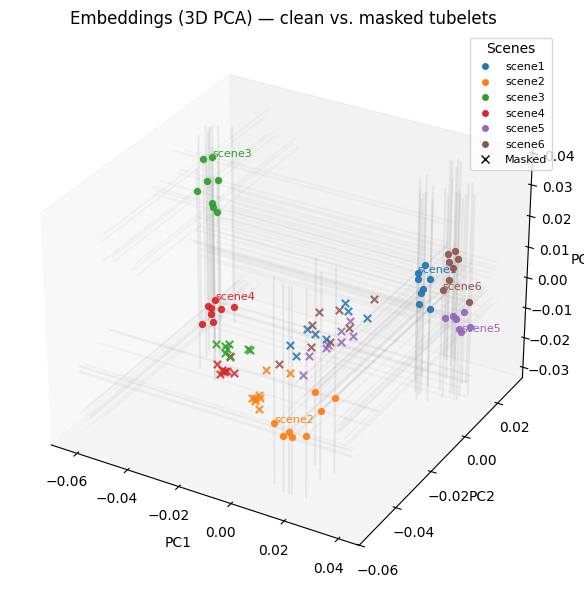

In [54]:

# 3d plotting

# Colors by scene
scenes_unique = sorted({m[0] for m in meta})
palette = plt.cm.get_cmap('tab10').colors
color_map = {s: palette[i % len(palette)] for i, s in enumerate(scenes_unique)}

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

# ground-truth embeddings (circles)
for (x, y, z), (scene, t_idx) in zip(emb_3d, meta):
    ax.scatter(x, y, z, color=color_map[scene], s=18, alpha=0.9)

# masked embeddings (x markers) overlaid on same PCA space
if emb_3d_masked is not None:
    for (x, y, z), (scene, _) in zip(emb_3d_masked, meta):
        ax.scatter(x, y, z, color=color_map[scene], s=28, alpha=0.85,
                   marker='x', linewidths=1.5)

# annotate one representative point per scene to avoid clutter
for scene in scenes_unique:
    k = next((i for i, m in enumerate(meta) if m[0] == scene), None)
    if k is not None:
        xi, yi, zi = emb_3d[k]
        ax.text(xi, yi, zi, scene, fontsize=8, color=color_map[scene])

ax.grid(True)
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    try:
        axis._axinfo["grid"]["linewidth"] = 0.0
    except Exception:
        pass

# faint guides
mins, maxs = emb_3d.min(axis=0), emb_3d.max(axis=0)
for x, y, z in emb_3d:
    ax.plot([x, x], [y, y], [mins[2], maxs[2]], color='gray', alpha=0.12)
    ax.plot([x, x], [mins[1], maxs[1]], [z, z], color='gray', alpha=0.06)
    ax.plot([mins[0], maxs[0]], [y, y], [z, z], color='gray', alpha=0.06)

handles = [plt.Line2D([0],[0], marker='o', color='w', label=s,
                      markerfacecolor=color_map[s], markersize=6)
           for s in scenes_unique]
if emb_3d_masked is not None:
    handles.append(plt.Line2D([0],[0], marker='x', color='k', linewidth=0,
                              markeredgecolor='k', label='Masked'))
ax.legend(handles=handles, title='Scenes', loc='best', fontsize=8)

ax.set_title('Embeddings (3D PCA) — clean vs. masked tubelets')
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
plt.tight_layout()
plt.show()



/var/folders/61/qgw87yz91l7fqxmfslbk4wd40000gn/T/ipykernel_9459/4264947336.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab20').colors  # list of 10 RGBA colors


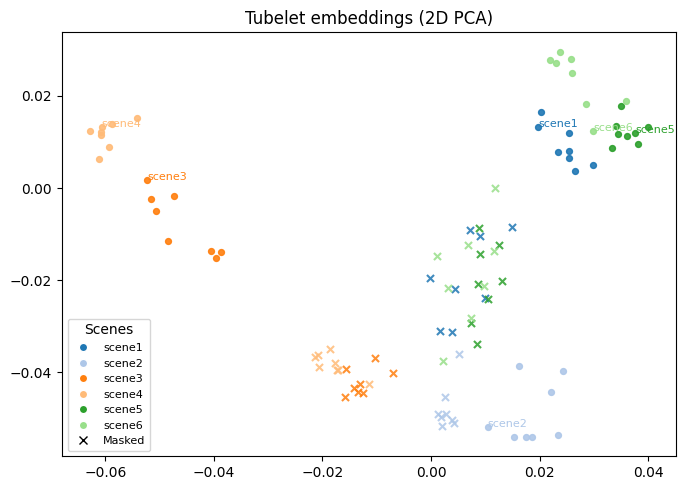

In [55]:

# 2d plotting

scenes_unique = sorted({m[0] for m in tubelet_meta})
palette = plt.cm.get_cmap('tab20').colors  # list of 10 RGBA colors
color_map = {s: palette[i % len(palette)] for i, s in enumerate(scenes_unique)}

plt.figure(figsize=(7, 5))
for (x, y), (scene, t_idx) in zip(emb_2d, tubelet_meta):
    plt.scatter(x, y, color=color_map[scene], s=18, alpha=0.9)

if 'emb_2d_masked' in globals() and emb_2d_masked is not None:
    for (x, y), (scene, _) in zip(emb_2d_masked, tubelet_meta):
        plt.scatter(x, y, color=color_map[scene], s=26, marker='x', linewidths=1.5,
                    alpha=0.85)

plt.title("Tubelet embeddings (2D PCA)")

for scene in scenes_unique:
    k = next(i for i, m in enumerate(tubelet_meta) if m[0] == scene)
    x, y = emb_2d[k]
    plt.text(x, y, scene, fontsize=8, color=color_map[scene])

handles = [plt.Line2D([0], [0], marker='o', color='w', label=s,
                      markerfacecolor=color_map[s], markersize=6)
           for s in scenes_unique]
if 'emb_2d_masked' in globals() and emb_2d_masked is not None:
    handles.append(plt.Line2D([0], [0], marker='x', color='k', linewidth=0,
                              markeredgecolor='k', label='Masked'))
plt.legend(handles=handles, loc='best', fontsize=8, title='Scenes')
plt.tight_layout()
plt.show()



In [ ]:
# implementing predictor head
